In [1]:
# Some parts of the following code are yet to be parametrized to the general J(n,k) x J(n,k) graph
# The used example is J(4,2) x J(4,2)
import math
import scipy.special
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile, BasicAer
from qiskit.circuit.library import SwapGate
from qiskit.tools.visualization import plot_histogram

In [2]:
# Johnson graph J(n,k) main parameters
n = 4
k = 2

nstates = int(scipy.special.binom(n, k))  # Number of vertices in a J(n,k) graph
degree = k*(n-k)  # J(n,k) degree
cnum = math.ceil(math.log2(int(scipy.special.binom(n, 2))))  # Required number of qubits for the coin register

state1_ = QuantumRegister(n, 'state1')
state2_ = QuantumRegister(n, 'state2')
sum_ = QuantumRegister(n, 'sum')
coin_ = QuantumRegister(cnum, 'coin')
clas_ = ClassicalRegister(n*2, 'measure')
qc = QuantumCircuit(state1_, state2_, sum_, coin_, clas_)

In [3]:
# Grover diffuser
grover_op = QuantumCircuit(cnum, name='grover_op')
for i in range(cnum):
    grover_op.h(i)
    grover_op.x(i)
grover_op.h(cnum-1)
grover_op.mcx([i for i in range(0, cnum-1)],[cnum-1])
grover_op.h(cnum-1)
for i in range(cnum):
    grover_op.x(i)
    grover_op.h(i)
grover_gate = grover_op.to_gate()
grover_control_gate = grover_op.to_gate().control(n)

In [4]:
def init():
    # Dicke state initialization on both state registers (TODO)
    qc.initialize([
        0, 0, 0, 1/np.sqrt(nstates), 0,
        1/np.sqrt(nstates), 1/np.sqrt(nstates), 0, 0,
        1/np.sqrt(nstates), 1/np.sqrt(nstates), 0, 1/np.sqrt(nstates),
        0, 0, 0
    ], [state1_[0], state1_[1], state1_[2], state1_[3]])
    qc.initialize([
        0, 0, 0, 1/np.sqrt(nstates), 0,
        1/np.sqrt(nstates), 1/np.sqrt(nstates), 0, 0,
        1/np.sqrt(nstates), 1/np.sqrt(nstates), 0, 1/np.sqrt(nstates),
        0, 0, 0
    ], [state2_[0], state2_[1], state2_[2], state2_[3]])

    # Uniform superposition initialization on the coin register
    for i in range(cnum):
        qc.h(coin_[i])

In [5]:
# The CNOT gates encode the following matrix:
#  [ 1 1 0 0,
#    1 0 1 1,
#    1 1 1 0,
#    0 1 0 1 ] for state_1
#  [ 1 0 1 0,
#    0 1 1 0,
#    1 1 0 1,
#    1 1 1 1 ] for state_2
# The controlled-Grover application checks whether a k-element subsets of the matrix's columns
#  XORs to the syndrome s = [1, 1, 0, 0]
def info_down():
    qc.barrier()

    qc.cx(state1_[0], sum_[0])
    qc.cx(state1_[0], sum_[1])
    qc.cx(state1_[0], sum_[2])
    qc.cx(state1_[1], sum_[0])
    qc.cx(state1_[1], sum_[2])
    qc.cx(state1_[1], sum_[3])
    qc.cx(state1_[2], sum_[1])
    qc.cx(state1_[2], sum_[2])
    qc.cx(state1_[3], sum_[1])
    qc.cx(state1_[3], sum_[3])
    
    qc.cx(state2_[0], sum_[0])
    qc.cx(state2_[0], sum_[2])
    qc.cx(state2_[0], sum_[3])
    qc.cx(state2_[1], sum_[1])
    qc.cx(state2_[1], sum_[2])
    qc.cx(state2_[1], sum_[3])
    qc.cx(state2_[2], sum_[0])
    qc.cx(state2_[2], sum_[1])
    qc.cx(state2_[2], sum_[3])
    qc.cx(state2_[3], sum_[2])
    qc.cx(state2_[3], sum_[3])
    
def info_down_unc():
    qc.barrier()
    
    qc.cx(state2_[3], sum_[3])
    qc.cx(state2_[3], sum_[2])
    qc.cx(state2_[2], sum_[3])
    qc.cx(state2_[2], sum_[1])
    qc.cx(state2_[2], sum_[0])
    qc.cx(state2_[1], sum_[3])
    qc.cx(state2_[1], sum_[2])
    qc.cx(state2_[1], sum_[1])
    qc.cx(state2_[0], sum_[3])
    qc.cx(state2_[0], sum_[2])
    qc.cx(state2_[0], sum_[0])
    
    qc.cx(state1_[3], sum_[3])
    qc.cx(state1_[3], sum_[1])
    qc.cx(state1_[2], sum_[2])
    qc.cx(state1_[2], sum_[1])
    qc.cx(state1_[1], sum_[3])
    qc.cx(state1_[1], sum_[2])
    qc.cx(state1_[1], sum_[0])
    qc.cx(state1_[0], sum_[2])
    qc.cx(state1_[0], sum_[1])
    qc.cx(state1_[0], sum_[0])

In [6]:
# The coin phase first applies a Grover operator regardless of the current state space, then reapplies it according to the oracle's output
def coin_phase():
    qc.barrier()
    
    qc.append(grover_gate, [coin_[i] for i in range(cnum)])
    
    qc.x(sum_[2])
    qc.x(sum_[3])
    qc.append(grover_control_gate, [sum_[i] for i in range(n)] + [coin_[i] for i in range(cnum)])
    qc.x(sum_[3])
    qc.x(sum_[2])

In [7]:
# SWAP sequence (TODO)
swapping = SwapGate().control(num_ctrl_qubits=cnum)
def shift_phase():    
    qc.barrier()
    
    qc.append(swapping, [coin_[0], coin_[1], coin_[2], state1_[0], state1_[1]])
    qc.append(swapping, [coin_[0], coin_[1], coin_[2], state2_[0], state2_[1]])
    qc.x(coin_[0])
    qc.append(swapping, [coin_[0], coin_[1], coin_[2], state1_[2], state1_[3]])
    qc.append(swapping, [coin_[0], coin_[1], coin_[2], state2_[2], state2_[3]])
    qc.x(coin_[0])
    qc.x(coin_[1])
    qc.append(swapping, [coin_[0], coin_[1], coin_[2], state1_[0], state1_[2]])
    qc.append(swapping, [coin_[0], coin_[1], coin_[2], state2_[0], state2_[2]])
    qc.x(coin_[0])
    qc.append(swapping, [coin_[0], coin_[1], coin_[2], state1_[1], state1_[3]])
    qc.append(swapping, [coin_[0], coin_[1], coin_[2], state2_[1], state2_[3]])
    qc.x(coin_[0])
    qc.x(coin_[1])
    qc.x(coin_[2])
    qc.append(swapping, [coin_[0], coin_[1], coin_[2], state1_[0], state1_[3]])
    qc.append(swapping, [coin_[0], coin_[1], coin_[2], state2_[0], state2_[3]])
    qc.x(coin_[0])
    qc.append(swapping, [coin_[0], coin_[1], coin_[2], state1_[1], state1_[2]])
    qc.append(swapping, [coin_[0], coin_[1], coin_[2], state2_[1], state2_[2]])
    qc.x(coin_[0])
    qc.x(coin_[2])

In [8]:
init()
nsteps = 2
for _ in range(nsteps):
    info_down()
    coin_phase()
    info_down_unc()
    shift_phase()
    
qc.barrier()

qc.measure([state1_[i] for i in range(n)] + [state2_[i] for i in range(n)], [clas_[i] for i in range(2*n)])

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


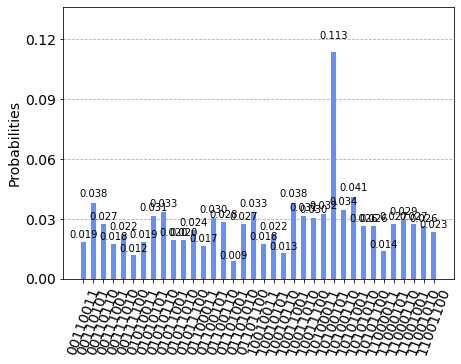

In [9]:
# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(qc, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts)

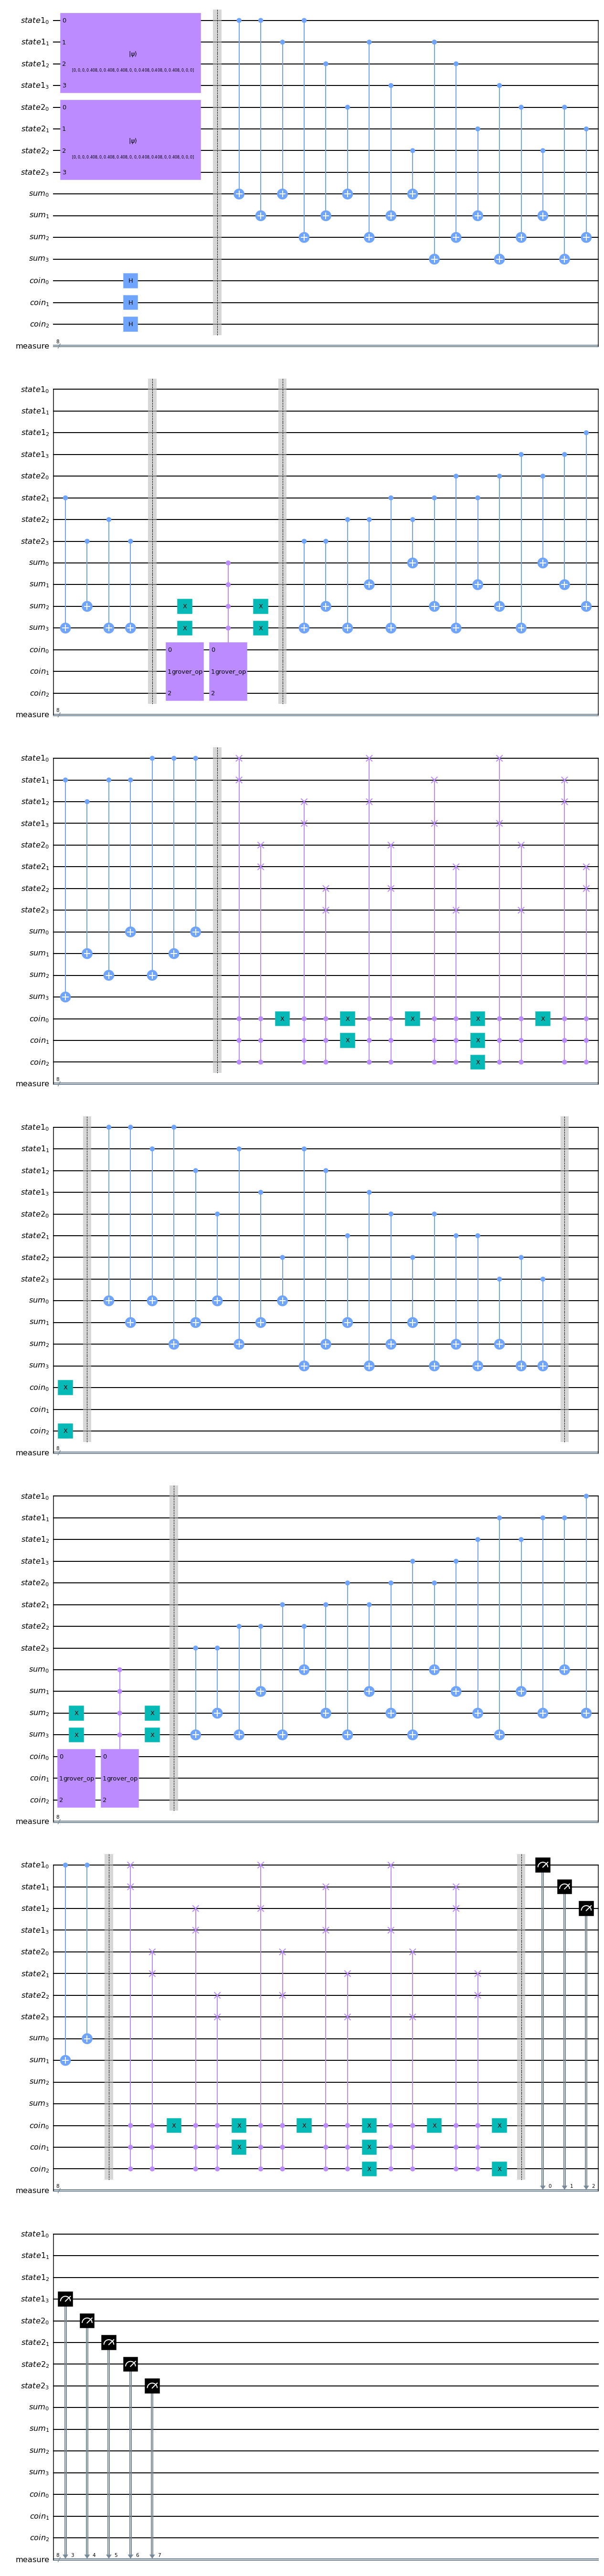

In [10]:
qc.draw()